Google Drive'a yüklediğimiz sıkıştırılmış UrbanSound8K dosyasını dışa aktaralım

Dosya dizinini `UrbanSound8K.tar.gz` dosyasını işaret edecek şekilde düzenleyin



In [1]:
!tar -xf  '/content/drive/MyDrive/Colab Notebooks/UrbanSound8K.tar.gz' -C /content/

In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, Image

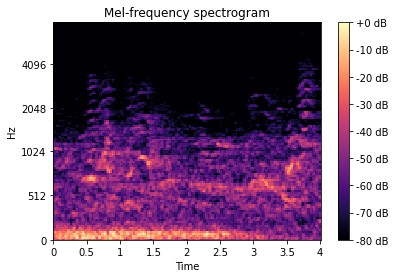

In [5]:
def create_spectogram(y):
    spec = librosa.feature.melspectrogram(y=y)
    spec_conv = librosa.amplitude_to_db(spec, ref=np.max)
    return spec_conv

def save_spectogram(y, path, show=False):
    spec_conv = create_spectogram(y)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(spec_conv, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    if show is True:
        plt.show()
    plt.savefig(path)
    plt.close() # inline figur gosteriminden kacis

test_file = '/content/UrbanSound8K/audio/fold1/108362-2-0-29.wav'

y, sr = librosa.load(test_file)
!mkdir -p /content/spectograms/vanilla /content/spectograms/noiseless # Dizin yoksa olustur

S_PATH = '/content/spectograms/'

save_spectogram(y, 'spectograms/vanilla_test.png', True)

In [4]:
Audio(test_file)

Ses dosyalarındaki gürültüyü ayıklamak için ```noisereduce``` kütüphanesini indirelim



In [ ]:
!pip install noisereduce

Gürültü temizleme fonksiyonunu test edelim

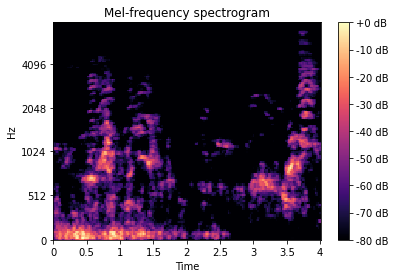

In [6]:
import noisereduce as nr
import soundfile as sf

reduced = nr.reduce_noise(y, sr) # Gurultuyu azalt
save_spectogram(reduced, 'spectograms/noiseless_test.png', show=True)

out_path = '/content/reduced_test.wav' 
sf.write(out_path, reduced, sr, subtype='PCM_24') # Gurultusu azaltilmis ses dosyasini sadece test icin kaydedelim

In [7]:
Audio(out_path)

In [10]:
import pandas as pd
df = pd.read_csv('/content/UrbanSound8K/metadata/UrbanSound8K.csv').sample(n=10)
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
5016,196058-2-0-0.wav,196058,0.000000,2.797256,1,9,2,children_playing
3634,17480-2-0-35.wav,17480,17.500000,21.500000,2,4,2,children_playing
4581,186334-2-0-20.wav,186334,10.000000,14.000000,1,3,2,children_playing
3738,17615-3-0-0.wav,17615,35.115512,39.115512,2,3,3,dog_bark
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
8200,82024-3-0-4.wav,82024,24.651009,28.651009,2,7,3,dog_bark
4381,180937-7-4-10.wav,180937,468.203523,472.203523,2,1,7,jackhammer
6025,30206-7-0-21.wav,30206,10.500000,14.500000,1,6,7,jackhammer
1390,134717-0-0-18.wav,134717,9.000000,13.000000,1,1,0,air_conditioner
1591,139000-4-0-2.wav,139000,1.000000,5.000000,1,8,4,drilling


*classID*'lerin dosya isminde encoded olduğunu gözlemlediğimize göre
Spectogramları oluştururken categorize etmek için tekrar dataframe'e bakmak yerine,
```filename.split('-')[1]```
Kullanabiliriz 



In [37]:
import os

audio_base_dir = '/content/UrbanSound8K/audio'

def all_spectograms(in_path, out_path):
    for directory in [d for d in os.listdir(in_path) if d[:4] == 'fold']: # S== 'fold10']:   # 
      dir = os.path.join(in_path, directory)
      dirname = directory[4:]
      num_files = []
      for spec_type in ['vanilla/', 'noiseless/']: # Cikti dizini yoksa olustur
        for catgry in range(10):
          out_dir = out_path + spec_type + str(catgry)
          if not os.path.exists(out_dir):   
            os.makedirs(out_dir)
            print('Directory Created: ' + out_dir)
        else:
          num_files.append(len(os.listdir(out_dir)))
      
      if os.path.isdir(dir):
        for filename in os.listdir(dir):
          f = os.path.join(dir, filename)
          if filename[-3:] == 'wav':  # tar.gz dışa aktarılırken oluşan gizli dosyadan kaçış
            data, rate = librosa.load(f)
            fname = filename[:-3]
            category = filename.split('-')[1]
            v_path = out_path + 'vanilla/' + category + '/' + fname + 'png'
            n_path = out_path + 'noiseless/' + category + '/' + fname + 'png'


            print('Creating, Vanilla Spectogram for: ' + f)
            try:
              save_spectogram(data, v_path)   # Vanilla spectogram olusturur
            except Exception as e:
              print("The error raised is: ", e)
              print('Vanilla Spectogram creation failed for file:' + filename)
            
            print('Creating, Noiseless Spectogram for: ' + f)
            noiseless = nr.reduce_noise(data, rate)
            try:
              save_spectogram(noiseless, n_path) # Gurultusuz spectogram olusturur
            except Exception as e:
              print("The error raised is: ", e)
              print('Noiseless Spectogram creation failed for file:' + filename)


In [ ]:
all_spectograms(audio_base_dir, S_PATH)

In [31]:
for dir in range(10):
  v_path = S_PATH + 'vanilla/' + str(dir)
  n_path = S_PATH + 'noiseless/' + str(dir)
  print(f'Vanilla Spectogram Count: {len(os.listdir(v_path))}')
  print(f'Noiseless Spectogram Count: {len(os.listdir(n_path))}')

Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 429
Noiseless Spectogram Count: 429
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 374
Noiseless Spectogram Count: 374
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000
Vanilla Spectogram Count: 929
Noiseless Spectogram Count: 929
Vanilla Spectogram Count: 1000
Noiseless Spectogram Count: 1000


Bir test dosyayı seçip orjinal ve gürültüden arındırılmış spectogramlara göz atalım

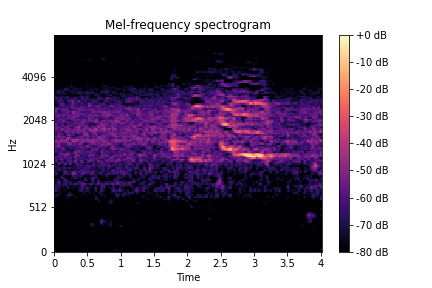

In [33]:
test_file = '2/104421-2-0-7.png'
v_test_file = S_PATH + 'vanilla/' + test_file
n_test_file = S_PATH + 'noiseless/' + test_file

Image(v_test_file)

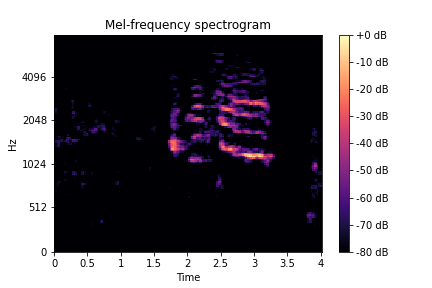

In [34]:
Image(n_test_file)

Oluşturulan spectogramları diğer notebooklarda kullanmak için drive'a yedekler

In [ ]:
%rm /content/spectograms/noiseless_test.png /content/spectograms/vanilla_test.png
%cp -av /content/spectograms '/content/drive/MyDrive/Colab Notebooks/'